<a href="https://colab.research.google.com/github/2ovisa/AH2179/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stop ahead prediction
- intressant för resenärer att veta hur stor förseningen blir vid sitt stop
- intressant för resenärer att veta hur stor förseningen är vid sin påstigande station

##Data Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

#-------------------------------------------------data preprocessing------------------------------------------------------------------

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/ProjectAssignmentData/Dataset-PT.csv'
df = pd.read_csv(url, header = 1)
print(df.head(1))
#df.info()
#print(df.columns.tolist())
#df = df.iloc[:1000]



   Calendar_date  route_id  bus_id  stop_sequence  arrival_delay  dwell_time  \
0       20220108         4   41344              1            151           0   

   travel_time_for_previous_section  scheduled_travel_time  \
0                                 0                    120   

   upstream_stop_delay  origin_delay  ...  factor(weather)Rain  \
0                  100           100  ...                    0   

   factor(weather)Snow  factor(temperature)Cold  \
0                    0                        0   

   factor(temperature)Extra_cold factor(temperature)Normal  \
0                              0                         1   

  factor(day_of_week)weekday factor(day_of_week)weekend  \
0                          0                          1   

  factor(time_of_day)Afternoon_peak  factor(time_of_day)Morning_peak  \
0                                 0                                0   

   factor(time_of_day)Off-peak  
0                            1  

[1 rows x 31 columns]


###Kolumner att droppa:
- Identifiers: Calender_date, route_id, bus_id (innehåller inte nödvändig information
- They who leak future knowledge: Arrival_delay (should be target)
- Dummies: To avoid multi collineraty one of the examples should be dropped. factor(temperature)Normal, (weather)normal, weekend, off-peak. *these become the baseline?*


In [2]:
#skapa unika trippar
df = df.sort_values(['bus_id', 'Calendar_date', 'stop_sequence']).reset_index(drop=True)

df['trip_number'] = df.groupby(['bus_id','Calendar_date', 'stop_sequence']).cumcount()
df['unique_trip'] = (
    df['bus_id'].astype(str) + '_' +
    df['Calendar_date'].astype(str) + '_' +
    df['trip_number'].astype(str)
)


In [ ]:
#Dubbelkolla så att tripparna är unika och har count = 27
df.groupby('unique_trip')['stop_sequence'].agg(['min','max','count']).sort_values('count')


,min,max,count
unique_trip,,,
45716_20220225_0,1,27,27
45711_20220630_2,1,27,27
45711_20220630_1,1,27,27
45711_20220630_0,1,27,27
45709_20220224_0,1,27,27
...,...,...,...
45780_20220512_2,1,27,27
45792_20220308_0,1,27,27
45807_20220510_0,1,27,27


In [ ]:
# 1) Varje trip har exakt stoppen 1..27
stops_ok = (
    df.groupby('unique_trip')['stop_sequence']
      .apply(lambda s: set(s.tolist()) == set(range(1,28)))
      .all()
)
print('Stops exakt 1..27 per trip:', stops_ok)

# 2) Strikt stigande med steg 1 inom varje trip
mono_ok = (
    df.groupby('unique_trip')['stop_sequence']
      .apply(lambda s: (s.diff().fillna(1) == 1).all())
      .all()
)
print('Strikt +1 mellan rader inom trip:', mono_ok)

# 3) Horizons pekar h stopp framåt inom samma trip
for h in [1,3,6,12]:
    s_future = df.groupby('unique_trip')['stop_sequence'].shift(-h)
    ok = (s_future.dropna() - df.loc[s_future.notna(), 'stop_sequence'] == h).all()
    print(f'H={h} korrekt skift:', ok)

# 4) Inga korsningar mellan trips vid skift
for h in [1,3,6,12]:
    uid_future = df.groupby('unique_trip')['unique_trip'].shift(-h)
    cross_ok = (uid_future.dropna() == df.loc[uid_future.notna(), 'unique_trip']).all()
    print(f'H={h} ingen kors-trip:', cross_ok)


In [3]:
#multi horizon targets
#df = df.sort_values(['unique_trip', 'stop_sequence'])

for h in [1,3,6,12]:
  df[f'arrival_delay_t+{h}'] = df.groupby('unique_trip')['arrival_delay'].shift(-h)

# ta bort rader som saknar alla  target
targets = [f"arrival_delay_t+{h}" for h in [1, 3, 6, 12]]
df = df[df[targets].notna().any(axis=1)].copy()

*Why is arrival_delay used and not stop sequence?*
- *stop sequence is just an index telling which stop number in the trip. It only contains ordering, not delay information*
- *the code says "for stop i, the target is the arrival delay at stop i+1*

*this assumes each stop is ~5 minutes apart. If travel times vary a lot, then “t+5 min” might not really equal “next stop”*

In [4]:
# 3. FEATURE ENGINEERING (temporala + dynamiska features)
#-------------------------------------------------
# Normaliserad stopp-position
df["stop_sequence_norm"] = df.groupby("unique_trip")["stop_sequence"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Stopp kvar till slutet
df["stops_remaining"] = df.groupby("unique_trip")["stop_sequence"].transform(
    lambda x: x.max() - x
)

# Differens i försening mot föregående stopp
df["delay_diff"] = df.groupby("unique_trip")["arrival_delay"].diff().fillna(0)

# Glidande medelvärde (3 stopp bakåt)
df["delay_ma3"] = df.groupby("unique_trip")["arrival_delay"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
df["delay_trend"] = df["arrival_delay"] - df["delay_ma3"]


*använda ovan för visualisation, för varför annars ska dessa vara med?*

In [5]:
unique_trips = df["unique_trip"].unique()
split_point = int(len(unique_trips) * 0.8)
train_trips = unique_trips[:split_point]
test_trips = unique_trips[split_point:]

# skapa mask
train_mask = df["unique_trip"].isin(train_trips)
test_mask = ~train_mask



In [6]:
#skapa kopia innan droppa för visualisering
df_vis = df.copy()

drop_cols = [
    "Calendar_date", "bus_id", "route_id", "arrival_time",
    "unique_trip", "new_trip", "trip_number"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Baseline dummies tas bort för att undvika multikollinearitet
to_drop = ["factor(weather)Normal", "factor(temperature)Normal",
           "factor(day_of_week)weekend", "factor(time_of_day)Off-peak"]
df = pd.get_dummies(df, drop_first=False)

df = df.drop(columns=[c for c in to_drop if c in df.columns], errors="ignore")

#existing ITS
df_existing_its = df.copy()
drop_its = ['upstream_stop_delay',
'previous_bus_delay',
'previous_trip_travel_time',
'travel_time_for_previous_section',
'dwell_time',
'traffic_condition',
'recurrent_delay',
'delay_diff',
'delay_ma3',
'delay_trend']
df_existing_its = df_existing_its.drop(columns=[c for c in drop_its if c in df.columns])

- *if stop_sequence is a freature, the model might cheat by just learning that higher stop numbers mean later in the trip*

In [7]:
# --- features/targets ---
X = df.drop(["arrival_delay"] + targets, axis=1, errors="ignore")
y = df[targets]

#fyll saknade targetvärden för de sista stoppen
y = y.fillna(method='ffill').fillna(method='bfill')

/tmp/ipython-input-1820583009.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method='ffill').fillna(method='bfill')


In [ ]:
print(X.columns)

Index(['stop_sequence', 'dwell_time', 'travel_time_for_previous_section',
       'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay',
       'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition',
       'recurrent_delay', 'factor(weather)Light_Rain',
       'factor(weather)Light_Snow', 'factor(weather)Rain',
       'factor(weather)Snow', 'factor(temperature)Cold',
       'factor(temperature)Extra_cold', 'factor(day_of_week)weekday',
       'factor(time_of_day)Afternoon_peak', 'factor(time_of_day)Morning_peak',
       'stop_sequence_norm', 'stops_remaining', 'delay_diff', 'delay_ma3',
       'delay_trend', 'weather_Light Rain', 'weather_Light Snow',
       'weather_Normal', 'weather_Rain', 'weather_Snow', 'temperature_Cold',
       'temperature_Extra cold', 'temperature_Normal', 'day_of_week_weekday',
       'day_of_week_weekend', 'time_of_day_AP', 'time_of_day_MP',
       'time_of_day_OP'],
      dtype='object')


In [10]:
#existing its
# --- features/targets ---
X_eits = df_existing_its.drop(["arrival_delay"] + targets, axis=1, errors="ignore")
y_eits = df_existing_its[targets]

#fyll saknade targetvärden för de sista stoppen
y_eits = y.fillna(method='ffill').fillna(method='bfill')

X_train_eits, X_test_eits = X_eits[train_mask], X_eits[test_mask]
y_train_eits, y_test_eits = y_eits[train_mask], y_eits[test_mask]

scaler = StandardScaler()

X_train_eits = scaler.fit_transform(X_train_eits)
X_test_eits = scaler.transform(X_test_eits)

/tmp/ipython-input-1777702104.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_eits = y.fillna(method='ffill').fillna(method='bfill')


In [8]:
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [9]:
#skala
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
#grid search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBRegressor

param_dist = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

rand_search = RandomizedSearchCV(
    XGBRegressor(tree_method='hist', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)
print("Best params:", rand_search.best_params_)


Best params: {'subsample': 0.9, 'n_estimators': 800, 'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.5}


In [ ]:
Best params: {'subsample': 0.9, 'n_estimators': 600, 'max_depth': 4, 'earning_rate': 0.05, 'colsample_bytree': 0.5}

##Multi-output models

###*KNN*

In [ ]:
X_train.dtypes.value_counts()

In [ ]:
models = {}
for h in [1,3,6,12]:
    y_h = df[f"arrival_delay_t+{h}"].dropna()
    X_h = X.loc[y_h.index]
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_h, y_h)
    models[h] = model

In [25]:
#multioutput utan wrapped
from sklearn.neighbors import KNeighborsRegressor


model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

- arrival_delay_t+1: MAE=28.51, R²=0.953
- arrival_delay_t+3: MAE=53.67, R²=0.809
- arrival_delay_t+6: MAE=83.94, R²=0.626
- arrival_delay_t+12: MAE=127.96, R²=0.350

###*Random Forest Regressor*

In [13]:
#multiout put utan wrapped
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Träna en enda multi-output RF
model = RandomForestRegressor(n_estimators=80, max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Prediktion
y_pred = model.predict(X_test)



- arrival_delay_t+1: MAE=20.98, R²=0.976
- arrival_delay_t+3: MAE=45.52, R²=0.858
- arrival_delay_t+6: MAE=74.72, R²=0.704
- arrival_delay_t+12: MAE=117.21, R²=0.464

###*LGBMR // XGBoost*

In [ ]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=-1, num_leaves=64)
model.fit(X_train, y_train)


In [10]:
#multiout put utan wrapped
from xgboost import XGBRegressor


# Träna en enda multi-output RF
model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.5,
        random_state=42,
        tree_method='hist'  #snabbare, mindre minne
    )
model.fit(X_train, y_train)

# Prediktion
y_pred = model.predict(X_test)


- arrival_delay_t+1: MAE=20.30, R²=0.942
- arrival_delay_t+3: MAE=46.05, R²=0.831
- arrival_delay_t+6: MAE=75.25, R²=0.683
- arrival_delay_t+12: MAE=117.92, R²=0.451


Utan ma3
- arrival_delay_t+1: MAE=21.44, R²=0.950
- arrival_delay_t+3: MAE=46.71, R²=0.838
- arrival_delay_t+6: MAE=75.57, R²=0.685
- arrival_delay_t+12: MAE=118.15, R²=0.453

In [33]:
#multioutput med wrapped
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor


#Multi-output XGBoost med parametrare från random search
xgb_model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.5,
        random_state=42,
        tree_method='hist'  #snabbare, mindre minne
    )
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)



- arrival_delay_t+1: MAE=20.41, R²=0.941
- arrival_delay_t+3: MAE=46.15, R²=0.831
- arrival_delay_t+6: MAE=75.42, R²=0.678
- arrival_delay_t+12: MAE=117.97, R²=0.450

In [30]:
#multioutput med wrapped
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor


#Multi-output XGBoost med parametrare från random search
model = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=80, max_depth=15, random_state=42)
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


- arrival_delay_t+1: MAE=19.37, RMSE=28.30, MAPE=56.90%, R²=0.979
- arrival_delay_t+3: MAE=44.86, RMSE=74.99, MAPE=99.29%, R²=0.860
- arrival_delay_t+6: MAE=74.41, RMSE=113.47, MAPE=141.67%, R²=0.705
- arrival_delay_t+12: MAE=117.58, RMSE=164.33, MAPE=188.95%, R²=0.452

##*Kedjad multi-output*

In [19]:
from sklearn.multioutput import RegressorChain
from xgboost import XGBRegressor


base_model = XGBRegressor(n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.5,
        random_state=42,
        tree_method='hist'  #snabbare, mindre minne
    )

chain = RegressorChain(base_model, order =[0,1,2,3]) #0=t+1,1=t+3 osv
chain.fit(X_train, y_train)

y_pred = chain.predict(X_test)

- arrival_delay_t+1: MAE=20.41, R²=0.941
- arrival_delay_t+3: MAE=45.78, R²=0.826
- arrival_delay_t+6: MAE=75.25, R²=0.664
- arrival_delay_t+12: MAE=117.25, R²=0.436

In [20]:
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

base_model = RandomForestRegressor(n_estimators=80, max_depth=15, random_state=42)

chain = RegressorChain(base_model, order =[0,1,2,3]) #0=t+1,1=t+3 osv
chain.fit(X_train, y_train)

y_pred = chain.predict(X_test)


Med RF:
- arrival_delay_t+1: MAE=19.37, R²=0.979
- arrival_delay_t+3: MAE=45.09, R²=0.859
- arrival_delay_t+6: MAE=74.46, R²=0.703
- arrival_delay_t+12: MAE=116.76, R²=0.465

In [ ]:
#existing its
from sklearn.multioutput import RegressorChain
from xgboost import XGBRegressor


base_model_eits = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=8,
                          subsample=0.8, colsample_bytree=0.8, random_state=42,
                          tree_method='hist')

chain = RegressorChain(base_model_eits, order =[0,1,2,3]) #0=t+1,1=t+3 osv
chain.fit(X_train_eits, y_train_eits)

y_pred_eits = chain.predict(X_test_eits)

In [37]:
#Skifta prediktionerna tillbaka
# skapa DataFrame med prediktioner
pred_df = pd.DataFrame(y_pred, columns=[f"pred_t+{h}" for h in [1,3,6,12]])
pred_df["stop_sequence"] = df_vis.loc[test_mask, "stop_sequence"].values
pred_df["unique_trip"] = df_vis.loc[test_mask, "unique_trip"].values
pred_df["arrival_delay"] = df_vis.loc[test_mask, "arrival_delay"].values

# skifta tillbaka så att varje prediktion hamnar vid sitt "målstopp"
for h in [1,3,6,12]:
    pred_df[f"pred_t+{h}_aligned"] = (
        pred_df.groupby("unique_trip")[f"pred_t+{h}"].shift(h)
    )


###LSTM

In [ ]:
#BYGG SEKVSENSER MED FLERA HORISONTER
import numpy as np

timesteps = 5   # antal tidigare stops att använda
horizons = [1, 3, 6, 12]   # hur många stops framåt vi ska förutsäga
features = ["arrival_delay", "stop_sequence_norm", "stops_remaining"]

X_list, y_list = [], []

for trip_id, trip_data in df_vis.groupby("unique_trip"):
    arr = trip_data[features].values
    delays = trip_data["arrival_delay"].values

    for i in range(len(trip_data) - timesteps - max(horizons)):
        # input sequence (5 stops bakåt)
        X_list.append(arr[i:i+timesteps])

        # target: delays vid horisonterna
        y_list.append([delays[i+timesteps+h-1] for h in horizons])

X = np.array(X_list)   # shape: (samples, timesteps, features)
y = np.array(y_list)   # shape: (samples, len(horizons))


In [ ]:
#TRAIN AND TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [ ]:
#BYGG EN LSTM FÖR MULTI OYPUT
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, X.shape[2])))
model.add(Dense(len(horizons)))   # en output per horisont
model.compile(optimizer="adam", loss="mae")

model.summary()


In [ ]:
#TRÄNA
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)


In [ ]:
#UTVÄRDERA
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score

for i, h in enumerate(horizons):
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    r2  = r2_score(y_test[:, i], y_pred[:, i])
    print(f"Horizon t+{h}: MAE={mae:.2f}, R²={r2:.3f}")


- Horizon t+1: MAE=24.47, R²=0.904
- Horizon t+3: MAE=41.38, R²=0.855
- Horizon t+6: MAE=61.27, R²=0.782
- Horizon t+12: MAE=87.11, R²=0.681

##Evalutation

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importances from your multi-output model
importances = model.feature_importances_

# Turn into Series
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Show top 10
print(feat_imp.head(5))

# Plot
plt.figure(figsize=(8,6))
feat_imp.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importances (Shared across all horizons)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


AttributeError: 'MultiOutputRegressor' object has no attribute 'feature_importances_'

XGBoost utan ma3
- upstream_stop_delay    0.379400
- origin_delay           0.121899
- stop_sequence_norm     0.063741
- stop_sequence          0.053801
- stops_remaining        0.048299

med ma3
- delay_ma3              0.307880
- upstream_stop_delay    0.171542
- origin_delay           0.095734
- stop_sequence          0.053191
- stop_sequence_norm     0.053163

RF:
- delay_ma3             0.734277
- stop_sequence         0.044823
- stop_sequence_norm    0.043814
- stops_remaining       0.043016
- origin_delay          0.021334
dtype: float64

In [31]:
#utvärdera xgboost
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# MAE per horisont
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

# RMSE per horisont
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))

# MAPE per horisont
mape = []
for i in range(y_test.shape[1]):
    actual = y_test.iloc[:, i].values
    pred = y_pred[:, i]
    # undvik division med noll
    mask = actual != 0
    mape.append(np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100)

# R² per horisont
r2 = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Utskrift
for i, col in enumerate(y_test.columns):
    print(f"{col}: MAE={mae[i]:.2f}, RMSE={rmse[i]:.2f}, MAPE={mape[i]:.2f}%, R²={r2[i]:.3f}")


arrival_delay_t+1: MAE=19.37, RMSE=28.30, MAPE=56.90%, R²=0.979
arrival_delay_t+3: MAE=44.86, RMSE=74.99, MAPE=99.29%, R²=0.860
arrival_delay_t+6: MAE=74.41, RMSE=113.47, MAPE=141.67%, R²=0.705
arrival_delay_t+12: MAE=117.58, RMSE=164.33, MAPE=188.95%, R²=0.452


In [ ]:
#utvärdera existing its
mae = mean_absolute_error(y_test_eits, y_pred_eits, multioutput='raw_values')
r2 = [r2_score(y_test_eits.iloc[:, i], y_pred_eits[:, i]) for i in range(y_test.shape[1])]

for i, col in enumerate(y_test_eits.columns):
    print(f"{col}: MAE={mae[i]:.2f}, R²={r2[i]:.3f}")

arrival_delay_t+1: MAE=96.16, R²=0.431
arrival_delay_t+3: MAE=107.66, R²=0.248
arrival_delay_t+6: MAE=121.36, R²=0.199
arrival_delay_t+12: MAE=143.41, R²=0.122


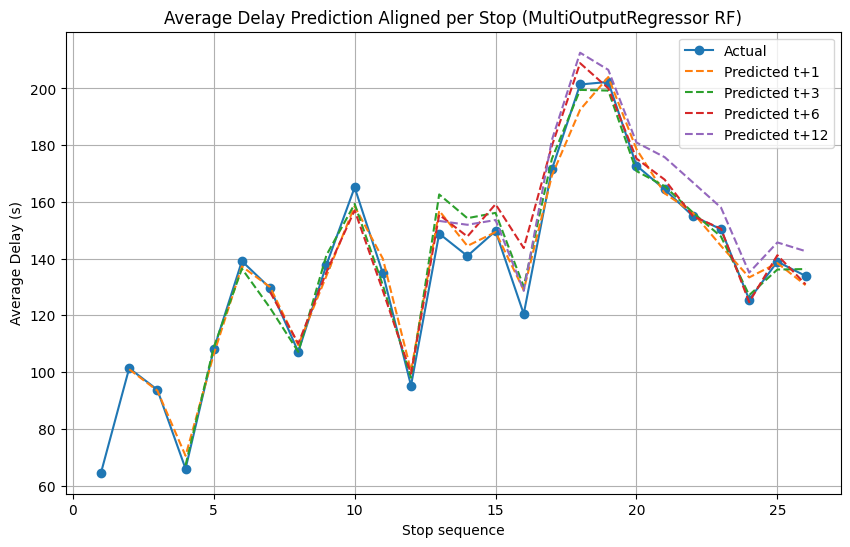

In [39]:
##visa medelvärdet per stopp över alla resor tillsammans med prediction
avg_aligned = pred_df.groupby("stop_sequence")[["arrival_delay"] +
    [f"pred_t+{h}_aligned" for h in [1,3,6,12]]].mean()

plt.figure(figsize=(10,6))
plt.plot(avg_aligned.index, avg_aligned["arrival_delay"], label="Actual", marker='o')
for h in [1,3,6,12]:
    plt.plot(avg_aligned.index, avg_aligned[f"pred_t+{h}_aligned"], '--', label=f"Predicted t+{h}")
plt.xlabel("Stop sequence")
plt.ylabel("Average Delay (s)")
plt.title("Average Delay Prediction Aligned per Stop (MultiOutputRegressor RF)")
plt.legend()
plt.grid(True)
plt.show()


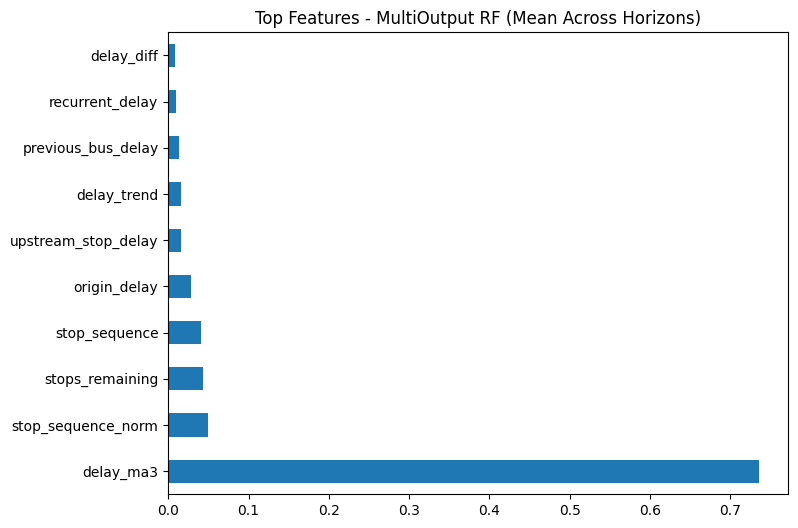

In [35]:
importances = []
for est in model.estimators_:
    importances.append(est.feature_importances_)

mean_importance = np.mean(importances, axis=0)

feat_imp = pd.Series(mean_importance, index=X.columns).sort_values(ascending=False)
feat_imp.head(10).plot(kind="barh", figsize=(8,6))
plt.title("Top Features - MultiOutput RF (Mean Across Horizons)")
plt.show()

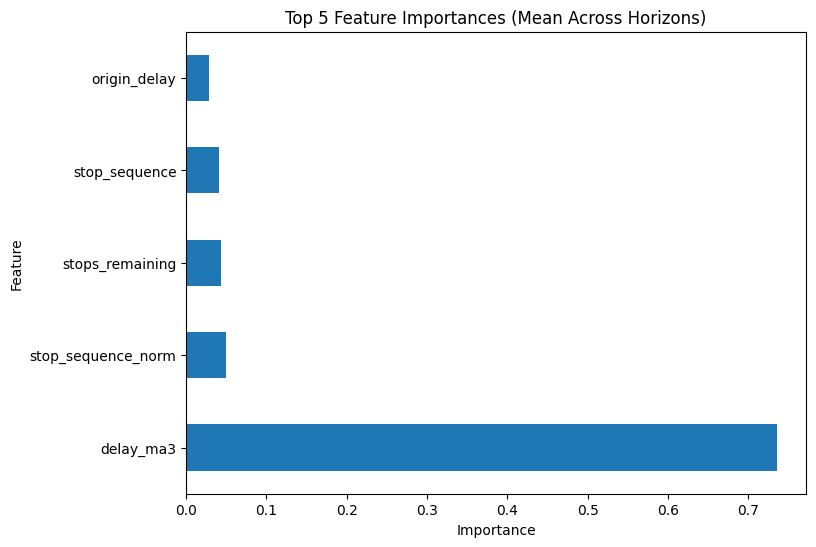

In [33]:
#Feature importance for XGB, vilken feature påverkar prediction mest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# samla importances från varje intern modell
importances = []
for i, est in enumerate(model.estimators_):
    imp = est.feature_importances_
    importances.append(imp)

# medelvärde över alla horisonter
mean_importance = np.mean(importances, axis=0)

# sortera och plotta
feat_imp = pd.Series(mean_importance, index=X.columns).sort_values(ascending=False)
feat_imp.head(5).plot(kind='barh', figsize=(8,6))
plt.title("Top 5 Feature Importances (Mean Across Horizons)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


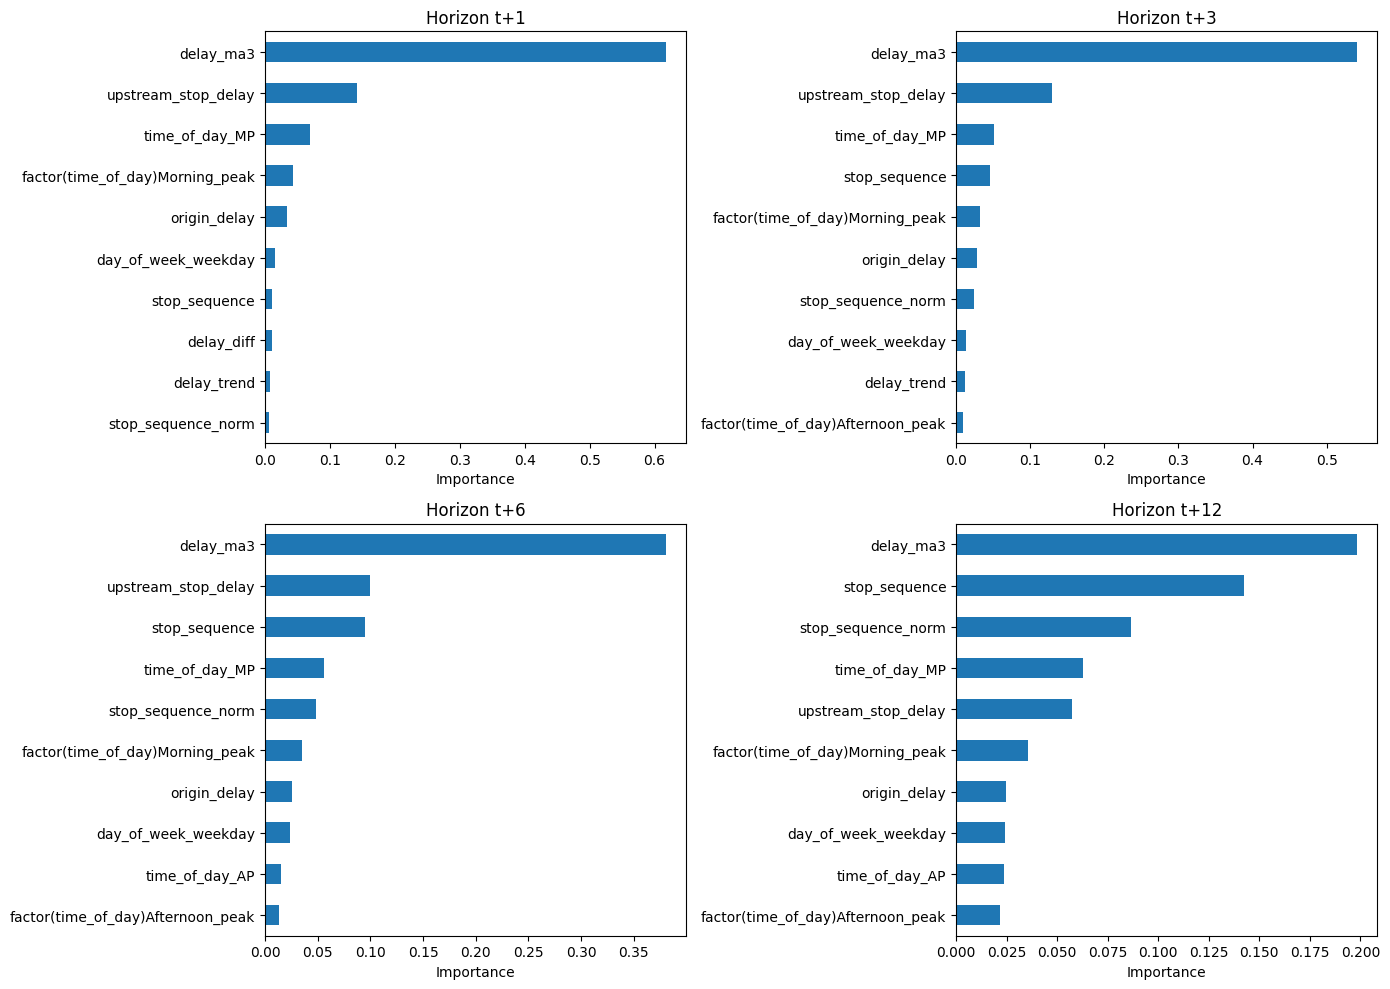

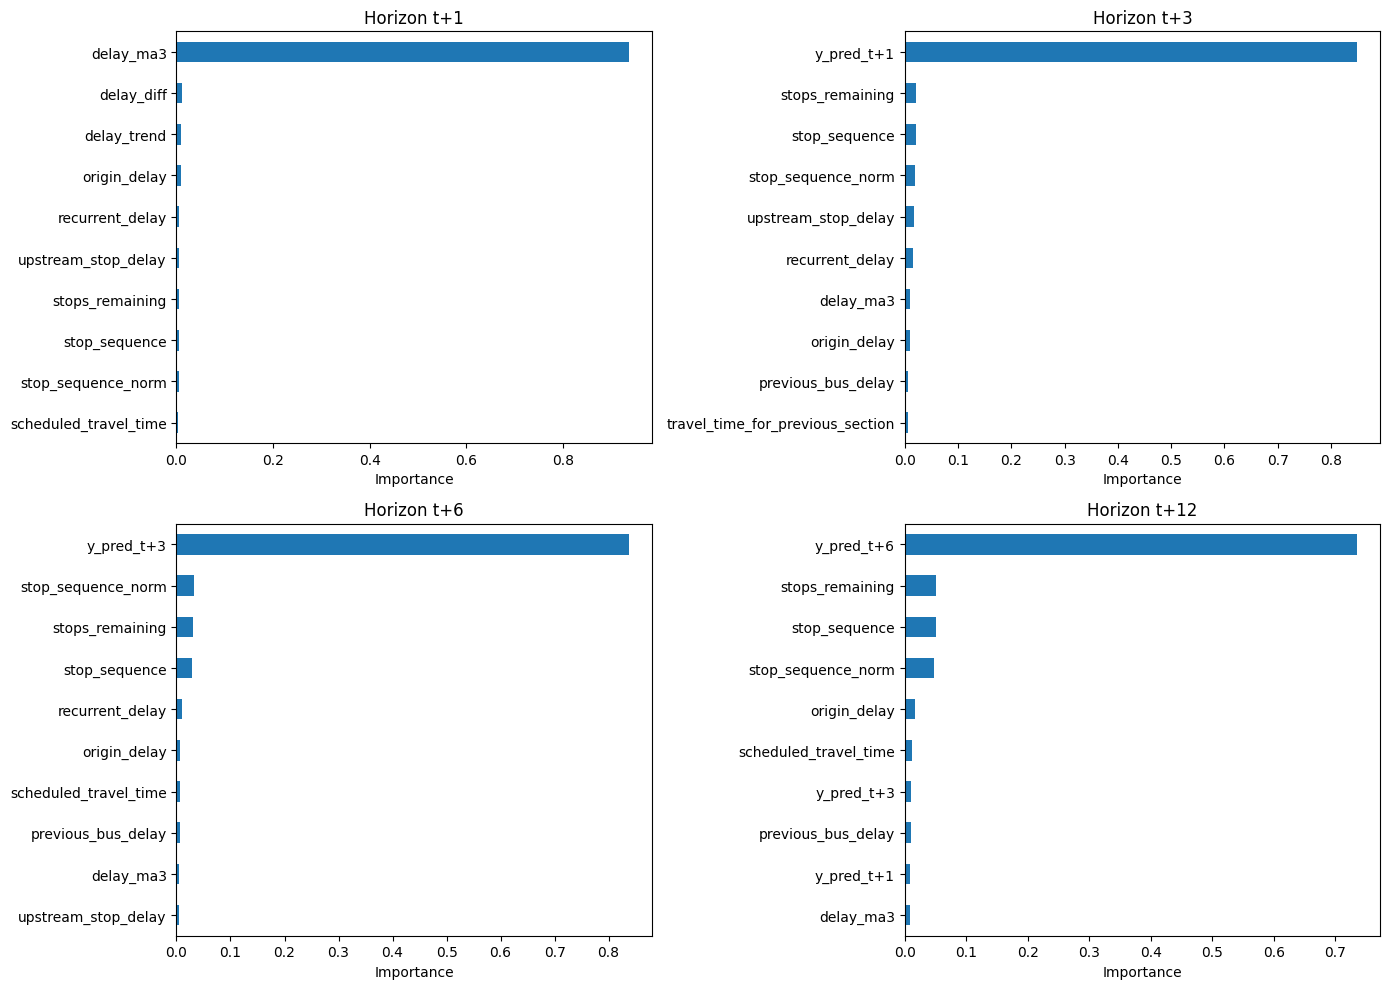

In [36]:
#Feature importance for RegressonChain
# collect feature importances per horizon
feature_names = list(X.columns)
importances = []
for i, est in enumerate(chain.estimators_):
    # base + previous predictions for later horizons
    extra = [f"y_pred_t+{[1,3,6,12][j]}" for j in range(i)]
    feats = feature_names + extra
    imp = pd.Series(est.feature_importances_, index=feats).sort_values(ascending=False)
    importances.append(imp)

# plot top features per horizon
plt.figure(figsize=(14, 10))
for i, (imp, h) in enumerate(zip(importances, [1,3,6,12])):
    plt.subplot(2, 2, i+1)
    top_imp = imp.head(10)
    top_imp[::-1].plot(kind="barh")  # reverse for readable order
    plt.title(f"Horizon t+{h}")
    plt.xlabel("Importance")
    plt.tight_layout()

plt.show()




KNN
- arrival_delay_t+1: MAE=28.51, R²=0.953
- arrival_delay_t+3: MAE=53.67, R²=0.809
- arrival_delay_t+6: MAE=83.94, R²=0.626
- arrival_delay_t+12: MAE=127.96, R²=0.350

single output
- t+1: MAE=18.31, R²=0.978
- t+3: MAE=32.48, R²=0.937
- t+6: MAE=46.89, R²=0.877
- t+12: MAE=70.30, R²=0.747

RF
- MAE for arrival_delay_t+1: 20.42
- MAE for arrival_delay_t+3: 37.31
- MAE for arrival_delay_t+6: 55.17
- MAE for arrival_delay_t+12: 81.35

XGBoost
- arrival_delay_t+1: MAE=19.95, R²=0.922
- arrival_delay_t+3: MAE=36.88, R²=0.878
- arrival_delay_t+6: MAE=54.21, R²=0.820
- arrival_delay_t+12: MAE=80.16, R²=0.725

med multi
- arrival_delay_t+1: MAE=19.37, R²=0.928
- arrival_delay_t+3: MAE=44.72, R²=0.817
- arrival_delay_t+6: MAE=73.83, R²=0.669
- arrival_delay_t+12: MAE=116.72, R²=0.441

RegressionChain
- arrival_delay_t+1: MAE=19.37, R²=0.928
- arrival_delay_t+3: MAE=44.70, R²=0.811
- arrival_delay_t+6: MAE=73.52, R²=0.668
- arrival_delay_t+12: MAE=115.88, R²=0.443

RegressionChain existing ITS
- arrival_delay_t+1: MAE=19.70, R²=0.919
- arrival_delay_t+3: MAE=45.06, R²=0.800
- arrival_delay_t+6: MAE=73.95, R²=0.659
- arrival_delay_t+12: MAE=116.26, R²=0.432

In [ ]:
#Korrelation mellan faktisk och predikterad försening per horisont

plt.figure(figsize=(12, 8))
for i, col in enumerate(y.columns):
    plt.subplot(2, 2, i+1)
    plt.scatter(y_test[col], y_pred[:, i], alpha=0.4)
    plt.plot([y_test[col].min(), y_test[col].max()],
             [y_test[col].min(), y_test[col].max()],
             "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{col} | R² = {r2_score(y_test[col], y_pred[:, i]):.2f}")
plt.tight_layout()
plt.show()

In [ ]:
# MAE över prediktionshorisonter: Visar hur prognosprecisionen försämras längre fram i rutten

plt.figure(figsize=(8,5))
plt.plot([1,3,6,12], mae, marker='o', label='MAE')
plt.title("MAE vs Prediction Horizon")
plt.xlabel("Stops Ahead")
plt.ylabel("Mean Absolute Error (s)")
plt.grid(True)
plt.show()


In [ ]:
#r2 över prediktionshorisonter: Visar hur prognosprecisionen försämras längre fram i rutten

r2_scores = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y.shape[1])]
plt.plot([1,3,6,12], r2_scores, marker='o')
plt.title("R² per Horizon")
plt.xlabel("Stops Ahead")
plt.ylabel("R²")
plt.grid(True)
plt.show()


In [ ]:
#distributioncheck
fig, axes = plt.subplots(len(targets), 1, figsize=(8, 16))
for i, col in enumerate(targets):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

MAE = the average absolute difference between the models predictions and the actual delay

- MAE for delay_t+1_stop: 34.00
- MAE for delay_t+3_stop: 46.54
- MAE for delay_t+6_stop: 54.66
- MAE for delay_t+12_stop: 56.01

This means that on average, the prediction for the next stop is off by 34 seconds.

Interpretations:
- Errors grow as the horizon length increases, which is expected since uncertainty accumulates further into the future


##*Hur påverkar yttre faktorer (tid på dygn, väder) prediktionsfelet?*

In [ ]:
residuals = y_test_eits.values - y_pred_eits
residuals_df = pd.DataFrame(residuals, columns=[f"res_t+{h}" for h in [1,3,6,12]])
residuals_df["factor(time_of_day)Afternoon_peak"] = df_vis.loc[test_mask, "factor(time_of_day)Afternoon_peak"].values
residuals_df["factor(time_of_day)Morning_peak"] = df_vis.loc[test_mask, "factor(time_of_day)Morning_peak"].values

residuals_df["factor(weather)Rain"] = df_vis.loc[test_mask, "factor(weather)Rain"].values
residuals_df["factor(weather)Snow"] = df_vis.loc[test_mask, "factor(weather)Snow"].values
residuals_df["factor(temperature)Cold"] = df_vis.loc[test_mask, "factor(temperature)Cold"].values
residuals_df["factor(temperature)Extra_cold"] = df_vis.loc[test_mask, "factor(temperature)Extra_cold"].values

residuals_df["factor(day_of_week)weekend"] = df_vis.loc[test_mask, "factor(day_of_week)weekend"].values




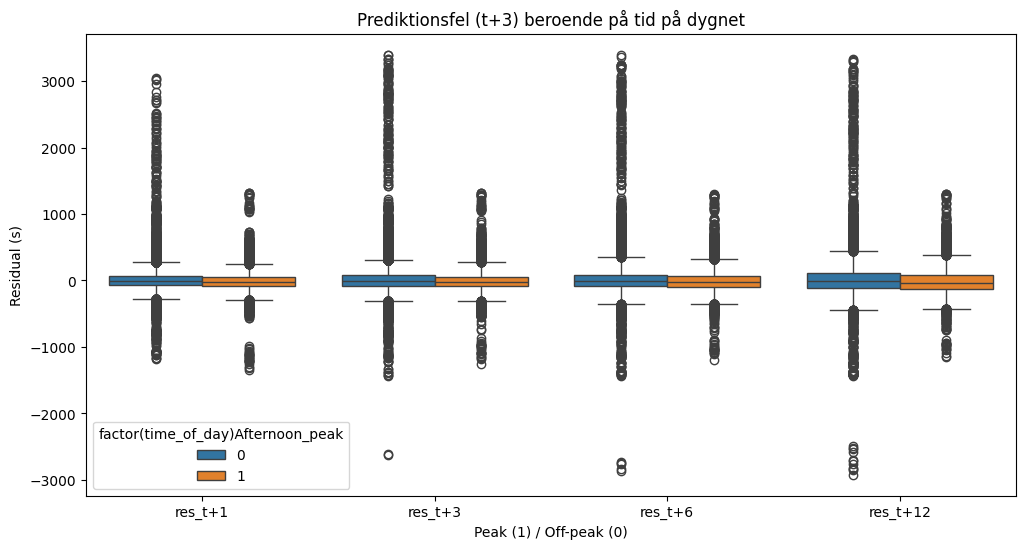

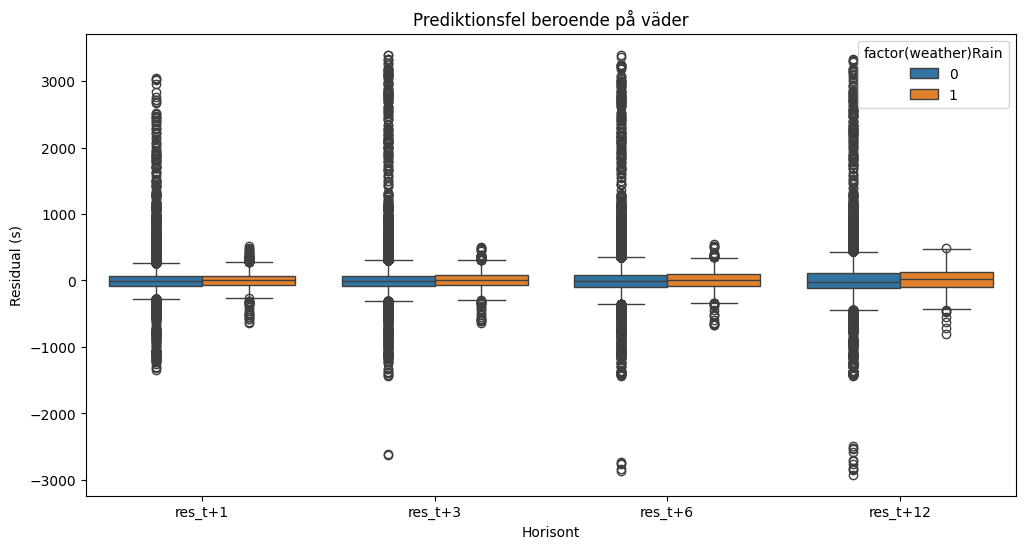

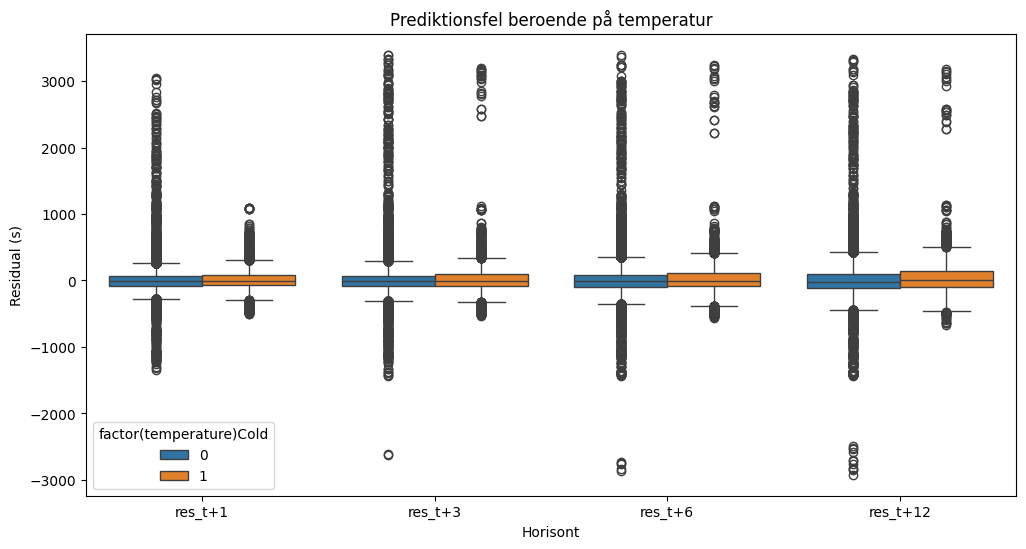

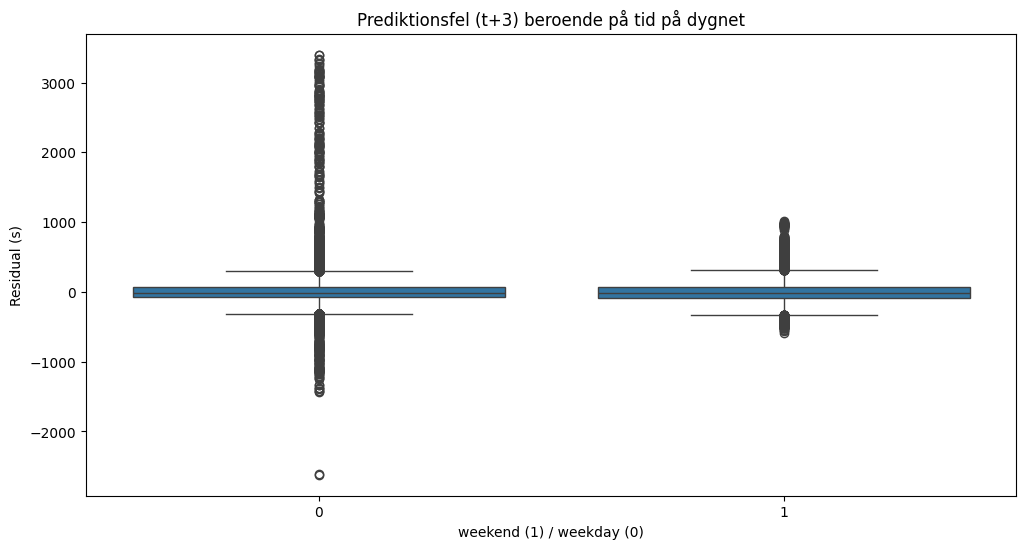

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=residuals_df.melt(id_vars=["factor(time_of_day)Afternoon_peak", "factor(time_of_day)Morning_peak"],
                                   value_vars=[f"res_t+{h}" for h in [1,3,6,12]]),
            x="variable", y="value", hue="factor(time_of_day)Afternoon_peak")
plt.title("Prediktionsfel (t+3) beroende på tid på dygnet")
plt.xlabel("Peak (1) / Off-peak (0)")
plt.ylabel("Residual (s)")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=residuals_df.melt(id_vars=["factor(weather)Rain", "factor(weather)Snow"],
                                   value_vars=[f"res_t+{h}" for h in [1,3,6,12]]),
            x="variable", y="value", hue="factor(weather)Rain")
plt.title("Prediktionsfel beroende på väder")
plt.xlabel("Horisont")
plt.ylabel("Residual (s)")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=residuals_df.melt(id_vars=["factor(temperature)Cold", "factor(temperature)Extra_cold"],
                                   value_vars=[f"res_t+{h}" for h in [1,3,6,12]]),
            x="variable", y="value", hue="factor(temperature)Cold")
plt.title("Prediktionsfel beroende på temperatur")
plt.xlabel("Horisont")
plt.ylabel("Residual (s)")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=residuals_df, x="factor(day_of_week)weekend", y="res_t+3")
plt.title("Prediktionsfel (t+3) beroende på tid på dygnet")
plt.xlabel("weekend (1) / weekday (0)")
plt.ylabel("Residual (s)")
plt.show()



In [ ]:
for factor in ["factor(time_of_day)Afternoon_peak", "factor(time_of_day)Morning_peak", "factor(weather)Rain", "factor(weather)Snow", "factor(temperature)Cold", "factor(temperature)Extra_cold"]:
    print(f"\nMAE per kategori för {factor}:")
    print(residuals_df.groupby(factor)[[f"res_t+{h}" for h in [1,3,6,12]]].apply(lambda x: np.mean(np.abs(x))))



MAE per kategori för factor(time_of_day)Afternoon_peak:
factor(time_of_day)Afternoon_peak
0    117.795177
1    114.923171
dtype: float64

MAE per kategori för factor(time_of_day)Morning_peak:
factor(time_of_day)Morning_peak
0    113.785816
1    131.501913
dtype: float64

MAE per kategori för factor(weather)Rain:
factor(weather)Rain
0    117.116590
1    122.610391
dtype: float64

MAE per kategori för factor(weather)Snow:
factor(weather)Snow
0    117.055239
1    133.081258
dtype: float64

MAE per kategori för factor(temperature)Cold:
factor(temperature)Cold
0    116.293893
1    124.100958
dtype: float64

MAE per kategori för factor(temperature)Extra_cold:
factor(temperature)Extra_cold
0    117.324621
1    108.104535
dtype: float64


*olika dummies och deras relation till arrival delay*
- tror inte detta är jätteintressant för min analys

In [ ]:
# skapa en kategori från de one-hot-kodade väderkolumnerna
weather_cols = [c for c in df_vis.columns if "factor(weather)" in c]
df_vis["weather_category"] = df_vis[weather_cols].idxmax(axis=1).str.replace("factor(weather)", "")

sns.boxplot(x="weather_category", y="arrival_delay", data=df_vis)
plt.title("Arrival Delay by Weather Condition")
plt.show()

In [ ]:
tod_cols = [c for c in df_vis.columns if "factor(time_of_day)" in c]
df_vis["time_of_day_category"] = df_vis[tod_cols].idxmax(axis=1).str.replace("factor(time_of_day)", "")

sns.boxplot(x="time_of_day_category", y="arrival_delay", data=df_vis)
plt.title("Arrival Delay by Time of Day")
plt.show()

In [ ]:
dow_cols = [c for c in df_vis.columns if "factor(day_of_week)" in c]
df_vis["day_category"] = df_vis[dow_cols].idxmax(axis=1).str.replace("factor(day_of_week)", "")

sns.boxplot(x="day_category", y="arrival_delay", data=df_vis)
plt.title("Arrival Delay by Weekday/Weekend")
plt.show()

#ITS

In [ ]:
existingITS_features =